# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

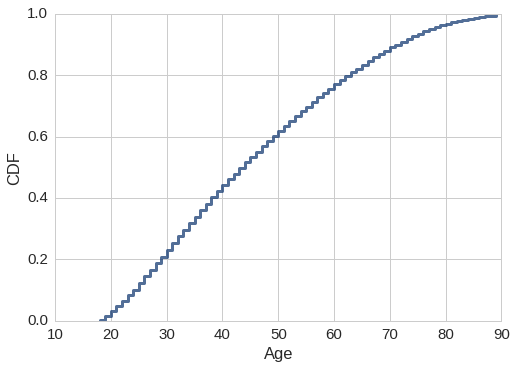

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

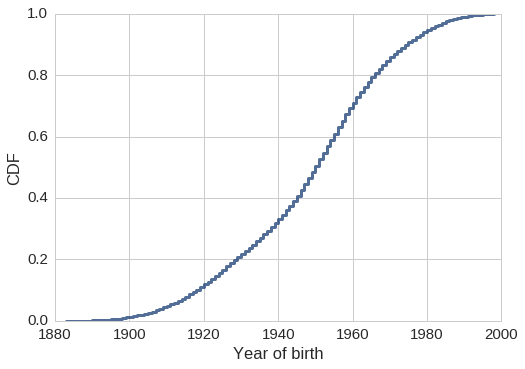

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [19]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [20]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [21]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10
0,1972,NaN,NaN,1932.0,40.0,0.8893,0,1.0,9,49,NaN,42.5,1932.5,1930.0
1,1972,NaN,NaN,1949.0,23.0,0.8893,0,1.0,12,884,NaN,22.5,1947.5,1940.0
2,1972,NaN,NaN,1951.0,21.0,1.3339,0,2.0,12,740,NaN,22.5,1952.5,1950.0
3,1972,NaN,NaN,1916.0,56.0,1.3339,0,1.0,6,12,NaN,57.5,1917.5,1910.0
4,1972,NaN,NaN,1898.0,74.0,0.8893,0,1.0,12,1090,NaN,72.5,1897.5,1890.0


## How does religious affiliation change with age?

In [22]:
varnames = ['prot', 'cath', 'none', 'other']

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # the second line lumps "Orthodox-Christian" and "Christian" with Protestant
    #df['prot'] = (df.relig==1)
    df['prot'] = (df.relig.isin([1,10,11]))

    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(sample)

Group by decade of birth and age group.

In [23]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [24]:
counts = grouped.none.count().unstack()
counts

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,38.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,191.0,134.0,96.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,423.0,494.0,331.0,238.0,156.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,582.0,741.0,677.0,646.0,424.0,227.0,172.0
1920.0,NaN,NaN,NaN,NaN,NaN,88.0,709.0,1005.0,967.0,900.0,724.0,582.0,371.0,274.0,158.0
1930.0,NaN,NaN,NaN,81.0,609.0,981.0,967.0,963.0,801.0,698.0,664.0,503.0,373.0,171.0,12.0
1940.0,NaN,123.0,862.0,1100.0,1144.0,1306.0,1405.0,1184.0,1075.0,948.0,648.0,339.0,35.0,NaN,NaN
1950.0,357.0,1511.0,1602.0,1613.0,1610.0,1680.0,1592.0,1305.0,1097.0,539.0,75.0,NaN,NaN,NaN,NaN
1960.0,302.0,1593.0,1595.0,1620.0,1578.0,1489.0,1068.0,713.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [25]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.047120,0.007463,0.020833
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.052009,0.036437,0.015106,0.033613,0.032051
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080460,0.027491,0.045884,0.026588,0.026316,0.033019,0.039648,0.075581
1920.0,NaN,NaN,NaN,NaN,NaN,0.034091,0.040903,0.019900,0.034126,0.024444,0.046961,0.039519,0.061995,0.058394,0.088608
1930.0,NaN,NaN,NaN,0.061728,0.055829,0.040775,0.044467,0.046729,0.036205,0.041547,0.073795,0.075547,0.061662,0.093567,0.333333
1940.0,NaN,0.211382,0.093968,0.085455,0.096154,0.067381,0.081139,0.082770,0.097674,0.094937,0.128086,0.064897,0.028571,NaN,NaN
1950.0,0.109244,0.114494,0.134831,0.096094,0.105590,0.119048,0.144472,0.132567,0.134913,0.159555,0.066667,NaN,NaN,NaN,NaN
1960.0,0.129139,0.132454,0.120376,0.141358,0.155260,0.134318,0.190075,0.208976,0.173333,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [26]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [27]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.061728,0.055829,0.040775,0.044467,0.046729,0.036205,0.041547,0.073795,0.075547,0.061662,0.093567,NaN
1940.0,NaN,0.211382,0.093968,0.085455,0.096154,0.067381,0.081139,0.082770,0.097674,0.094937,0.128086,0.064897,NaN,NaN,NaN
1950.0,0.109244,0.114494,0.134831,0.096094,0.105590,0.119048,0.144472,0.132567,0.134913,0.159555,0.066667,NaN,NaN,NaN,NaN
1960.0,0.129139,0.132454,0.120376,0.141358,0.155260,0.134318,0.190075,0.208976,0.173333,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.139073,0.189605,0.199206,0.224537,0.224186,0.249589,0.141176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.228296,0.283069,0.286916,0.314869,0.315315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

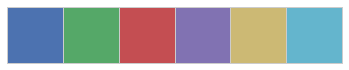

In [28]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

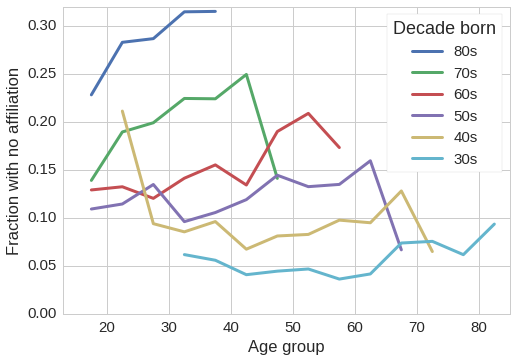

In [29]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

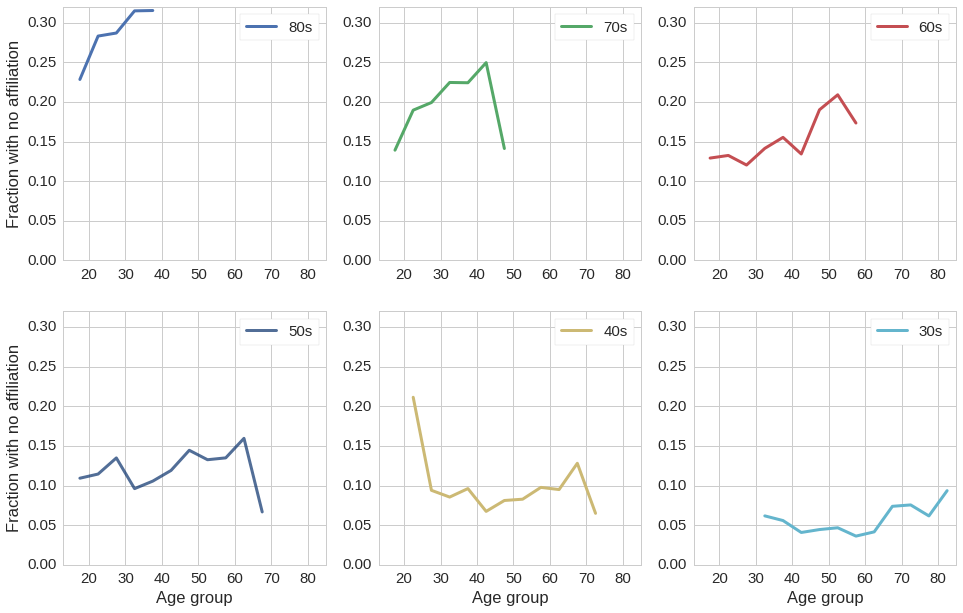

In [30]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [31]:
def center_factors(df):
    """Center factors around their means.
    
    df: DataFrame
    """
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2 / 1966
    df['age47'] = df.age - 47
    df['age472'] = df.age47**2 / 47

In [32]:
center_factors(sample)

In [33]:
formula = 'prot ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.665331
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 May 2017   Pseudo R-squ.:                 0.02135
Time:                        15:59:12   Log-Likelihood:                -41247.
converged:                       True   LL-Null:                       -42147.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0599      0.016      3.644      0.000       0.028       0.092
cohort66      -0.0201      0.001    -22.757      0.000      -0.022      -0.018
cohort662     -0.1284      0.036     -3.542      0.000      -0.200      -0.057
age47         -0.0011      0.001     -1.386      0.166      -0.003       0.000
age472        -0.0018      0.001     -1.219      0.223      -0.005       0.001
==============================================================================
"""

In [34]:
formula = 'cath ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.567198
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 May 2017   Pseudo R-squ.:                0.001790
Time:                        15:59:13   Log-Likelihood:                -35163.
converged:                       True   LL-Null:                       -35227.
                                        LLR p-value:                 2.606e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1255      0.019    -60.197      0.000      -1.162      -1.089
cohort66      -0.0062      0.001     -6.250      0.000      -0.008      -0.004
cohort662     -0.2548      0.040     -6.309      0.000      -0.334      -0.176
age47         -0.0059      0.001     -6.727      0.000      -0.008      -0.004
age472         0.0043      0.002      2.645      0.008       0.001       0.008
==============================================================================
"""

In [35]:
formula = 'none ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.338141
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 May 2017   Pseudo R-squ.:                 0.06691
Time:                        15:59:13   Log-Likelihood:                -20963.
converged:                       True   LL-Null:                       -22466.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4803      0.024    -62.820      0.000      -1.526      -1.434
cohort66       0.0431      0.001     35.833      0.000       0.041       0.045
cohort662     -0.0145      0.065     -0.223      0.823      -0.142       0.113
age47          0.0126      0.001      9.457      0.000       0.010       0.015
age472         0.0029      0.003      1.125      0.261      -0.002       0.008
==============================================================================
"""

In [36]:
formula = 'other ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.184385
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 May 2017   Pseudo R-squ.:                0.003099
Time:                        15:59:13   Log-Likelihood:                -11431.
converged:                       True   LL-Null:                       -11467.
                                        LLR p-value:                 1.343e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8487      0.037    -76.634      0.000      -2.922      -2.776
cohort66       0.0097      0.002      4.840      0.000       0.006       0.014
cohort662     -0.0953      0.085     -1.119      0.263      -0.262       0.072
age47          0.0066      0.002      3.606      0.000       0.003       0.010
age472         0.0004      0.003      0.114      0.910      -0.006       0.007
==============================================================================
"""

## Generational replacement

Choose colors

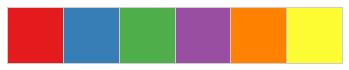

In [37]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [38]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [39]:
colors = [ORANGE, GREEN, RED, BLUE]
    
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of interview year.

In [40]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

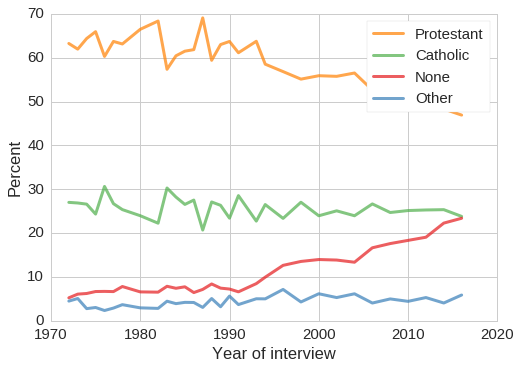

In [41]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

In [42]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1499
22.5    6261
27.5    6740
32.5    6396
37.5    6127
42.5    6153
47.5    5826
52.5    5257
57.5    4597
62.5    3904
67.5    3211
72.5    2614
77.5    1725
82.5    1053
87.5     632
Name: none, dtype: int64

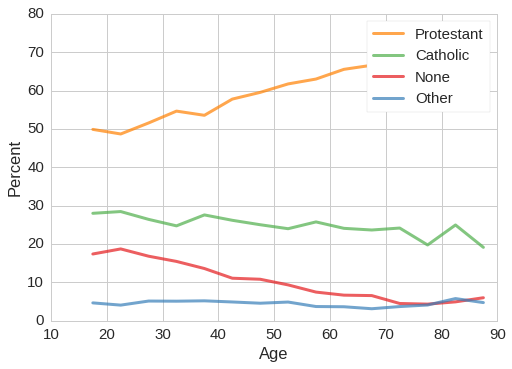

In [43]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [44]:
grouped_cohort = sample.groupby(['cohort5'])
grouped_cohort.relig.count()

cohort5
1882.5       6
1887.5      41
1892.5     121
1897.5     350
1902.5     654
1907.5    1066
1912.5    1451
1917.5    2105
1922.5    2757
1927.5    3021
1932.5    3155
1937.5    3668
1942.5    4516
1947.5    5653
1952.5    6444
1957.5    6537
1962.5    5704
1967.5    4329
1972.5    3476
1977.5    2768
1982.5    1995
1987.5    1317
1992.5     675
1997.5     186
Name: relig, dtype: int64

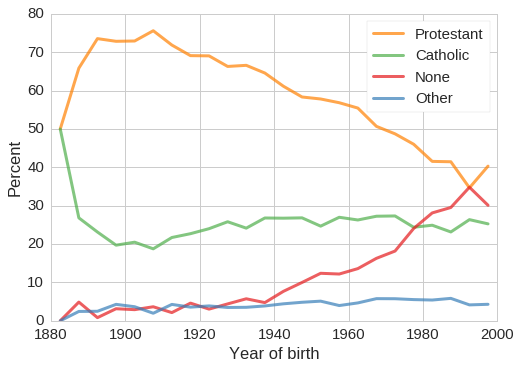

In [45]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [46]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    cohort: Series
    age: Series
    """
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [47]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,relig4,cohort66,cohort662,age47,age472,c,c2,a,a2,ac
0,1972,NaN,NaN,1932.0,40.0,0.8893,0,1.0,9,49,...,1.0,-34.0,0.587996,-7.0,1.042553,-34.0,1156.0,-7.0,49.0,238.0
1,1972,NaN,NaN,1949.0,23.0,0.8893,0,1.0,12,884,...,1.0,-17.0,0.146999,-24.0,12.255319,-17.0,289.0,-24.0,576.0,408.0
2,1972,NaN,NaN,1951.0,21.0,1.3339,0,2.0,12,740,...,2.0,-15.0,0.114446,-26.0,14.382979,-15.0,225.0,-26.0,676.0,390.0
3,1972,NaN,NaN,1916.0,56.0,1.3339,0,1.0,6,12,...,1.0,-50.0,1.271617,9.0,1.723404,-50.0,2500.0,9.0,81.0,-450.0
4,1972,NaN,NaN,1898.0,74.0,0.8893,0,1.0,12,1090,...,1.0,-68.0,2.351984,27.0,15.510638,-68.0,4624.0,27.0,729.0,-1836.0


Run logistic regression to fit models to each religious group.

In [48]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [49]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.664911
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 May 2017   Pseudo R-squ.:                 0.02197
Time:                        15:59:15   Log-Likelihood:                -41221.
converged:                       True   LL-Null:                       -42147.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0136      0.019     -0.702      0.483      -0.052       0.024
c             -0.0339      0.002    -16.072      0.000      -0.038      -0.030
c2            -0.0004   5.31e-05     -7.994      0.000      -0.001      -0.000
a             -0.0161      0.002     -7.244      0.000      -0.020      -0.012
a2            -0.0005   6.65e-05     -6.939      0.000      -0.001      -0.000
ac            -0.0008      0.000     -7.216      0.000      -0.001      -0.001
==============================================================================
"""

In [50]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.567122
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 May 2017   Pseudo R-squ.:                0.001924
Time:                        15:59:15   Log-Likelihood:                -35159.
converged:                       True   LL-Null:                       -35227.
                                        LLR p-value:                 1.562e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0892      0.022    -49.488      0.000      -1.132      -1.046
c              0.0004      0.002      0.178      0.859      -0.004       0.005
c2          4.111e-05   5.92e-05      0.695      0.487   -7.48e-05       0.000
a              0.0014      0.003      0.543      0.587      -0.004       0.006
a2             0.0003   7.38e-05      3.967      0.000       0.000       0.000
ac             0.0004      0.000      3.077      0.002       0.000       0.001
==============================================================================
"""

In [51]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.337808
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 May 2017   Pseudo R-squ.:                 0.06783
Time:                        15:59:15   Log-Likelihood:                -20942.
converged:                       True   LL-Null:                       -22466.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4005      0.026    -53.189      0.000      -1.452      -1.349
c              0.0612      0.003     20.096      0.000       0.055       0.067
c2             0.0005   8.44e-05      5.884      0.000       0.000       0.001
a              0.0321      0.003      9.788      0.000       0.026       0.038
a2             0.0007      0.000      6.185      0.000       0.000       0.001
ac             0.0011      0.000      6.491      0.000       0.001       0.001
==============================================================================
"""

In [52]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.184306
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 May 2017   Pseudo R-squ.:                0.003531
Time:                        15:59:16   Log-Likelihood:                -11426.
converged:                       True   LL-Null:                       -11467.
                                        LLR p-value:                 5.228e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9194      0.044    -66.114      0.000      -3.006      -2.833
c             -0.0042      0.005     -0.860      0.390      -0.014       0.005
c2            -0.0004      0.000     -3.314      0.001      -0.001      -0.000
a             -0.0086      0.005     -1.643      0.100      -0.019       0.002
a2            -0.0004      0.000     -2.696      0.007      -0.001      -0.000
ac            -0.0008      0.000     -3.120      0.002      -0.001      -0.000
==============================================================================
"""

In [56]:
formula = 'relig4 ~ c + c2 + a + a2 + ac'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.027101
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61977
Method:                           MLE   Df Model:                           15
Date:                Fri, 26 May 2017   Pseudo R-squ.:                 0.02768
Time:                        16:00:39   Log-Likelihood:                -63675.
converged:                       True   LL-Null:                       -65488.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6744      0.023    -28.953      0.000      -0.720      -0.629
c              0.0164      0.002      6.564      0.000       0.012       0.021
c2             0.0003   6.18e-05      4.096      0.000       0.000       0.000
a              0.0083      0.003      3.159      0.002       0.003       0.013
a2             0.0004   7.64e-05      5.369      0.000       0.000       0.001
ac             0.0006      0.000      4.942      0.000       0.000       0.001
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2676      0.045    -50.275      0.000      -2.356      -2.179
c              0.0122      0.005      2.445      0.014       0.002       0.022
c2            -0.0002      0.000     -1.344      0.179      -0.000    7.96e-05
a             -0.0008      0.005     -0.155      0.877      -0.011       0.010
a2            -0.0002      0.000     -1.318      0.188      -0.001       0.000
ac            -0.0004      0.000     -1.608      0.108      -0.001    9.45e-05
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9223      0.028    -33.388      0.000      -0.976      -0.868
c              0.0672      0.003     21.129      0.000       0.061       0.073
c2             0.0006   8.72e-05      6.621      0.000       0.000       0.001
a              0.0346      0.003     10.163      0.000       0.028       0.041
a2             0.0008      0.000      7.054      0.000       0.001       0.001
ac             0.0013      0.000      7.244      0.000       0.001       0.002
==============================================================================
"""

## Predict population

Predict future generations based on the models.

In [76]:
def predict_population(df, model_seq, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    age = df.loc[df.year>=2016, 'age']
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    pred = [results.predict(df).mean()
            for results in model_seq]
    return pd.Series(pred, index=varnames) * 100

In [77]:
pred = predict_population(sample, model_seq, 2016)
print(sum(pred))
pred

100.585250277


prot     46.633757
cath     24.993361
none     23.959394
other     4.998739
dtype: float64

In [78]:
pred = predict_population(sample, model_seq, 2026)
print(sum(pred))
pred

104.568406156


prot     37.003959
cath     25.251555
none     37.809420
other     4.503472
dtype: float64

In [79]:
pred = predict_population(sample, model_seq, 2036)
print(sum(pred))
pred

112.421716173


prot     26.653828
cath     25.691135
none     56.336675
other     3.740078
dtype: float64

In [80]:
def predict_by_year(sample, model_seq, years):
    """Make predictions by year.
    
    sample: DataFrame
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    df = pd.DataFrame(columns=varnames)
    for year in years:
        df.loc[year] = predict_population(sample, model_seq, year)
    return df

In [81]:
years = np.arange(1972, 2040)
df = predict_by_year(sample, model_seq, years)

In [82]:
def plot_predictions(series_seq):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

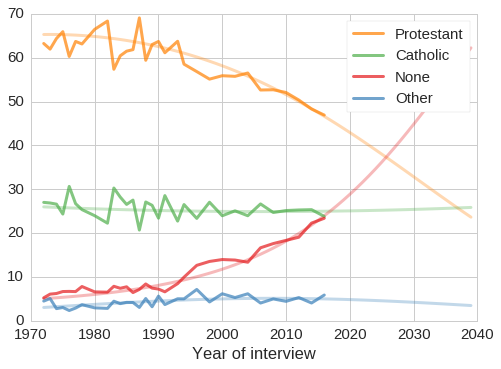

In [83]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

In [84]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='sag')
y = sample.relig4
X = sample[['c', 'a']].values
model.fit(X, y)
model.predict_proba(X).mean(axis=0)

array([ 0.58137285,  0.25542097,  0.04547095,  0.11773523])

In [85]:
def get_factors(df):
    return df[['c', 'c2', 'a', 'a2', 'ac']].values

def make_multi_model(df, y):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    model = LogisticRegression(multi_class='multinomial', solver='sag')
    X = get_factors(df)
    model.fit(X, y)
    return model

In [86]:
model = make_multi_model(sample, sample.relig4)

# looks like it might not be converging

In [92]:
def predict_multi_model(df, model, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    age = df.loc[df.year>=2016, 'age']
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = get_factors(df)
    pred = model.predict_proba(X).mean(axis=0)
    index = ['prot', 'cath', 'other', 'none']
    return pd.Series(pred, index=index) * 100

In [93]:
predict_multi_model(sample, model, 2016)

# not producing reasonable predictions

prot     26.358313
cath     27.782689
other    18.407514
none     27.451483
dtype: float64

## Belief in God

In [ ]:
varnames = ['strongbelief', 'belief', 'nobelief']

def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))

    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(sample)

In [ ]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
colors = [BLUE, PURPLE, RED]

In [ ]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

In [ ]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [ ]:
make_model(sample, 'strongbelief').summary()

In [ ]:
make_model(sample, 'belief').summary()

In [ ]:
make_model(sample, 'nobelief').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]

In [ ]:
plot_beliefs(grouped_cohort)
plot_predictions(series_seq)

thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(1991, 2040)
df = predict_by_year(sample, model_seq, years)
df

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [ ]:
sum(sample.conclerg.isnull())

In [ ]:
varnames = ['confident', 'someconf', 'noconf']

def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
    
create_conf_vars(sample)


In [ ]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

In [ ]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
make_model(sample, 'confident').summary()

In [ ]:
make_model(sample, 'someconf').summary()

In [ ]:
make_model(sample, 'noconf').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]


In [ ]:
plot_conf(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(1973, 2040)
df = predict_by_year(sample, model_seq, years)

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [ ]:
sum(sample.bible.isnull())

In [ ]:
varnames = ['word', 'inspired', 'legends']

def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(sample)

In [ ]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

In [ ]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
make_model(sample, 'word').summary()

In [ ]:
make_model(sample, 'inspired').summary()

In [ ]:
make_model(sample, 'legends').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]

In [ ]:
plot_bible(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(2017, 2040)
df = predict_by_year(sample, model_seq, years)

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')